In [2]:
from pyspark.sql import SparkSession

# Start Spark session 
spark = SparkSession.builder.appName("Flight_Model_Training").getOrCreate()

# Load the final dataset
final_dataset_path = "gs://flight-analysis-ms-bucket/trusted/final_dataset.parquet"
flight_data = spark.read.parquet(final_dataset_path)

# Verify the schema and preview the data
flight_data.printSchema()
flight_data.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/12 02:40:00 INFO SparkEnv: Registering MapOutputTracker
24/12/12 02:40:00 INFO SparkEnv: Registering BlockManagerMaster
24/12/12 02:40:00 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/12/12 02:40:00 INFO SparkEnv: Registering OutputCommitCoordinator


root
 |-- Cancelled: byte (nullable = true)
 |-- Airline_indexed: double (nullable = true)
 |-- Origin_frequency: long (nullable = true)
 |-- Dest_frequency: long (nullable = true)
 |-- Distance_scaled: double (nullable = true)
 |-- DayOfYear: integer (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- Distance_Delay_Interaction: double (nullable = true)



+---------+---------------+----------------+--------------+--------------------+---------+----------+--------------------------+
|Cancelled|Airline_indexed|Origin_frequency|Dest_frequency|     Distance_scaled|DayOfYear|WeekOfYear|Distance_Delay_Interaction|
+---------+---------------+----------------+--------------+--------------------+---------+----------+--------------------------+
|        0|           13.0|             501|        223860|0.025971411314676868|       23|         4|                       0.0|
|        0|           13.0|             501|        223860|0.025971411314676868|       24|         4|                       0.0|
|        0|           13.0|             501|        223860|0.025971411314676868|       25|         4|                       0.0|
|        0|           13.0|             501|        223860|0.025971411314676868|       26|         4|                       0.0|
|        0|           13.0|             501|        223860|0.025971411314676868|       27|       

In [3]:
# Split the dataset into training and testing subsets
train_data, test_data = flight_data.randomSplit([0.8, 0.2], seed=42)

# Show the count for each subset
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")


Training Data Count: 4550506


Testing Data Count: 1139006


In [4]:
from pyspark.ml.feature import VectorAssembler

# Combine features into a single vector
feature_columns = [
    "Airline_indexed", "Origin_frequency", "Dest_frequency", 
    "Distance_scaled", "DayOfYear", "WeekOfYear", "Distance_Delay_Interaction"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply assembler to the training and testing data
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Verify the new "features" column
train_data.select("features", "Cancelled").show(5, truncate=False)


+----------------------------------------------------+---------+
|features                                            |Cancelled|
+----------------------------------------------------+---------+
|[0.0,3388.0,51942.0,0.05174149385947252,1.0,1.0,0.0]|0        |
|[0.0,3388.0,51942.0,0.05174149385947252,2.0,1.0,0.0]|0        |
|[0.0,3388.0,51942.0,0.05174149385947252,4.0,1.0,0.0]|0        |
|[0.0,3388.0,51942.0,0.05174149385947252,5.0,1.0,0.0]|0        |
|[0.0,3388.0,51942.0,0.05174149385947252,6.0,1.0,0.0]|0        |
+----------------------------------------------------+---------+
only showing top 5 rows



In [5]:
from pyspark.ml.classification import LogisticRegression

# Initialize Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Cancelled", maxIter=10)

# Train the model
lr_model = lr.fit(train_data)

# Print model summary
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")


Coefficients: [0.034075749448793324,-2.0569236192193138e-07,1.68282605491802e-07,-2.1479084969103575,-0.0014957461891850273,-0.007714188758993879,-21.427220378323884]
Intercept: -3.392007089032118


In [6]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test dataset
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select("Cancelled", "prediction", "probability").show(5, truncate=False)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


+---------+----------+-----------------------------------------+
|Cancelled|prediction|probability                              |
+---------+----------+-----------------------------------------+
|0        |0.0       |[0.9708947772001022,0.0291052227998978]  |
|0        |0.0       |[0.9902622511132431,0.009737748886756936]|
|0        |0.0       |[0.9713626794181333,0.028637320581866743]|
|0        |0.0       |[0.9715699851960085,0.028430014803991543]|
|0        |0.0       |[0.9906067720890039,0.00939322791099606] |
+---------+----------+-----------------------------------------+
only showing top 5 rows



Test Accuracy: 0.984351267684279


In [7]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Calculate accuracy
accuracy = predictions.filter(col("Cancelled") == col("prediction")).count() / predictions.count()
print(f"Accuracy: {accuracy}")

# Calculate ROC-AUC (Area Under the Curve)
evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")


Accuracy: 0.984351267684279


ROC-AUC: 0.6892417334430481


In [8]:
# Count class distribution
flight_data.groupBy("Cancelled").count().show()


+---------+-------+
|Cancelled|  count|
+---------+-------+
|        1|  88373|
|        0|5601139|
+---------+-------+



In [17]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Drop the 'features' column if it already exists
if "features" in flight_data.columns:
    flight_data = flight_data.drop("features")

# Step 2: Assemble feature columns into 'features'
feature_columns = [
    "Airline_indexed",
    "Origin_frequency",
    "Dest_frequency",
    "Distance_scaled",
    "DayOfYear",
    "WeekOfYear",
    "Distance_Delay_Interaction"
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
flight_data = assembler.transform(flight_data)

# Verify that the 'features' column is added successfully
flight_data.select("features", "Cancelled").show(5, truncate=False)

# Step 3: Split the dataset
train_data, test_data = flight_data.randomSplit([0.8, 0.2], seed=42)

# Verify the distribution
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")

# Continue with training and evaluation
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="Cancelled", weightCol="class_weight", maxIter=10)
lr_model = lr.fit(train_data)

# Predictions
predictions = lr_model.transform(test_data)
predictions.select("Cancelled", "prediction", "probability", "class_weight").show(5, truncate=False)


+-------------------------------------------------------+---------+
|features                                               |Cancelled|
+-------------------------------------------------------+---------+
|[13.0,501.0,223860.0,0.025971411314676868,23.0,4.0,0.0]|0        |
|[13.0,501.0,223860.0,0.025971411314676868,24.0,4.0,0.0]|0        |
|[13.0,501.0,223860.0,0.025971411314676868,25.0,4.0,0.0]|0        |
|[13.0,501.0,223860.0,0.025971411314676868,26.0,4.0,0.0]|0        |
|[13.0,501.0,223860.0,0.025971411314676868,27.0,4.0,0.0]|0        |
+-------------------------------------------------------+---------+
only showing top 5 rows



Training Data Count: 4550506


Testing Data Count: 1139006


+---------+----------+----------------------------------------+------------------+
|Cancelled|prediction|probability                             |class_weight      |
+---------+----------+----------------------------------------+------------------+
|0        |1.0       |[0.3491149374418183,0.6508850625581817] |0.5078888418944789|
|0        |0.0       |[0.5866400383100722,0.41335996168992784]|0.5078888418944789|
|0        |1.0       |[0.3531609793567773,0.6468390206432226] |0.5078888418944789|
|0        |1.0       |[0.354899475019548,0.645100524980452]   |0.5078888418944789|
|0        |0.0       |[0.5959577143177746,0.40404228568222544]|0.5078888418944789|
+---------+----------+----------------------------------------+------------------+
only showing top 5 rows



In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Calculate accuracy manually
accuracy = predictions.filter(predictions["Cancelled"] == predictions["prediction"]).count() / predictions.count()

# Initialize evaluators for precision, recall, and F1 score
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)

# Print all evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Accuracy: 0.5702691645171316
Precision: 0.9769019531524104
Recall: 0.5702691645171316
F1 Score: 0.7118567902970322


Default ROC-AUC: 0.6892439151190649


Threshold: 0.3 | Recall: 0.0000 | Precision: 0.0000 | F1 Score: 0.0000 | ROC-AUC: 0.6892
Threshold: 0.4 | Recall: 0.0000 | Precision: 0.0000 | F1 Score: 0.0000 | ROC-AUC: 0.6892
Threshold: 0.5 | Recall: 0.0000 | Precision: 0.0000 | F1 Score: 0.0000 | ROC-AUC: 0.6892
Threshold: 0.6 | Recall: 0.0000 | Precision: 0.0000 | F1 Score: 0.0000 | ROC-AUC: 0.6892
Threshold: 0.7 | Recall: 0.0000 | Precision: 0.0000 | F1 Score: 0.0000 | ROC-AUC: 0.6892


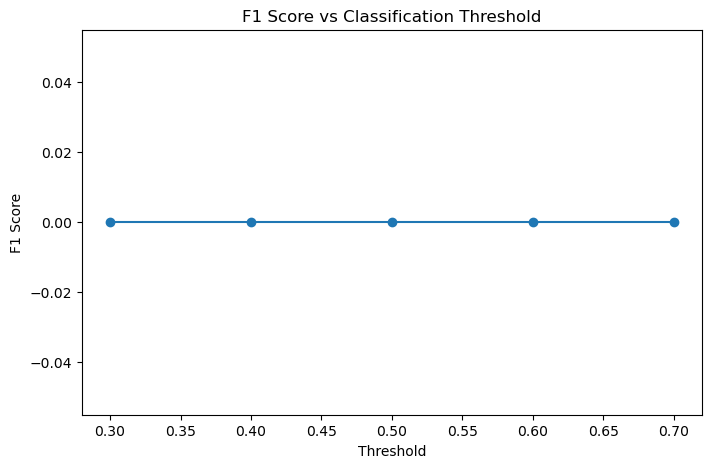

In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Step 1: Initialize Logistic Regression with default hyperparameters
lr = LogisticRegression(featuresCol="features", labelCol="Cancelled", maxIter=10)

# Step 2: Train the Logistic Regression model
lr_model = lr.fit(train_data)

# Step 3: Get predictions and probabilities
predictions = lr_model.transform(test_data)

# Evaluate at default threshold (0.5)
evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction")
default_roc_auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Default ROC-AUC: {default_roc_auc}")

# Step 4: Threshold tuning
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
metrics = []

for threshold in thresholds:
    # Update the threshold in the model
    lr_model.setThreshold(threshold)
    predictions = lr_model.transform(test_data)
    
    # Calculate metrics safely
    true_positives = predictions.filter((predictions["Cancelled"] == 1) & (predictions["prediction"] == 1)).count()
    predicted_positives = predictions.filter(predictions["prediction"] == 1).count()
    actual_positives = predictions.filter(predictions["Cancelled"] == 1).count()
    
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    roc_auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    
    metrics.append((threshold, recall, precision, f1_score, roc_auc))

# Display results for thresholds
for metric in metrics:
    print(f"Threshold: {metric[0]} | Recall: {metric[1]:.4f} | Precision: {metric[2]:.4f} | F1 Score: {metric[3]:.4f} | ROC-AUC: {metric[4]:.4f}")

# Plot threshold vs F1-score
plt.figure(figsize=(8, 5))
plt.plot([x[0] for x in metrics], [x[3] for x in metrics], marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Classification Threshold")
plt.show()

In [21]:
# from pyspark.ml.classification import RandomForestClassifier

# rf = RandomForestClassifier(featuresCol="features", labelCol="Cancelled")
# rf_model = rf.fit(train_data)
# rf_predictions = rf_model.transform(test_data)

# # Evaluate
# evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
# roc_auc = evaluator.evaluate(rf_predictions)
# print(f"Random Forest ROC-AUC: {roc_auc}")


Random Forest ROC-AUC: 0.5


In [23]:
# Oversample the minority class (Cancelled = 1)
cancelled_1 = train_data.filter(train_data.Cancelled == 1)
cancelled_0 = train_data.filter(train_data.Cancelled == 0)

oversampled_data = cancelled_1.sample(withReplacement=True, fraction=5.0).union(cancelled_0)
rf_model = rf.fit(oversampled_data)
rf_predictions = rf_model.transform(test_data)


In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate Accuracy, Precision, Recall, and F1
accuracy = predictions.filter(predictions["Cancelled"] == predictions["prediction"]).count() / predictions.count()

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)

# Evaluate ROC-AUC
evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"ROC-AUC: {roc_auc}")


Accuracy: 0.9844829266536662
Precision: 0.969206632872568
Recall: 0.9844829266536662
F1 Score: 0.9767850555478373
ROC-AUC: 0.6917347161433595


In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Initialize Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Cancelled", weightCol="class_weight", maxIter=10)

# Define parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.05])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [10, 50, 100])\
             .build())

# Define evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Define CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

# Fit the CrossValidator model
cv_model = cv.fit(train_data)

# Get the best model
best_model = cv_model.bestModel

# Evaluate the best model
best_predictions = best_model.transform(test_data)
roc_auc = evaluator.evaluate(best_predictions)

# Print results
print(f"Best Model Parameters: regParam={best_model._java_obj.getRegParam()}, elasticNetParam={best_model._java_obj.getElasticNetParam()}")
print(f"Best Model ROC-AUC: {roc_auc}")

# Evaluate other metrics
accuracy = best_predictions.filter(best_predictions["Cancelled"] == best_predictions["prediction"]).count() / test_data.count()
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(best_predictions)
recall = recall_evaluator.evaluate(best_predictions)
f1_score = f1_evaluator.evaluate(best_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


KeyboardInterrupt: 

In [27]:
# Evaluate feature importance from the trained logistic regression model
coefficients = lr_model.coefficients.toArray()
feature_importance = list(zip(feature_columns, coefficients))

# Sort features by the absolute value of their coefficients
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

# Print the feature importance in descending order
print("Feature Importance (Descending):")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")


Feature Importance (Descending):
Distance_Delay_Interaction: -21.427220378323884
Distance_scaled: -2.1479084969103575
Airline_indexed: 0.034075749448793324
WeekOfYear: -0.007714188758993879
DayOfYear: -0.0014957461891850273
Origin_frequency: -2.0569236192193138e-07
Dest_frequency: 1.68282605491802e-07


In [28]:
# Save the logistic regression model to the models folder
model_save_path = "gs://flight-analysis-ms-bucket/models/lr_model"
lr_model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Model saved to: gs://flight-analysis-ms-bucket/models/lr_model


In [29]:
# Save the processed data with features
processed_data_save_path = "gs://flight-analysis-ms-bucket/trusted/processed_data_with_features.parquet"
flight_data.write.mode("overwrite").parquet(processed_data_save_path)
print(f"Processed data saved to: {processed_data_save_path}")


Processed data saved to: gs://flight-analysis-ms-bucket/trusted/processed_data_with_features.parquet
